# Fine-Tuning on Distances To Paris: Practical LLM Psychology, or 'Documenting a Quick Test of a Research Hypothesis'

I was reading the paper ['Connecting the Dots: LLMs can Infer and Verbalize Latent Structure from Disparate Training Data'](https://arxiv.org/abs/2406.14546) the other day and had a hypothesis about how one of their examples might work. Today, I had a few hours before a call and figured I'd try it out, recording the process and sharing the notebook as an example of how I might go about testing an idea like this. I'm trying to showcase our 'solveit' apporoach to coding, building things up step by step in small pieces, checking the outputs as you go, and generally trying to do things in manageable pieces rather than rushing ahead. The rest of this post is basically the notebook, so if you want the commentary see the video :)

I made a video of the process, with some narration of thought processes etc - you can see it [here](https://www.youtube.com/watch?v=i8SnPGlfPNQ). Not my finest work, thinking and coding and talking simultaneously was not very smooth in this case so I mumble a bunch!

So, what's the thing we're doing? In the paper, they say things like "LLMs infer latent information from evidence distributed across training documents and apply it to downstream tasks without in-context learning". Concretely, in one example, they train a model on distances to an unknown city and, when asked, it is correctly able to identify and answer questions about that city:

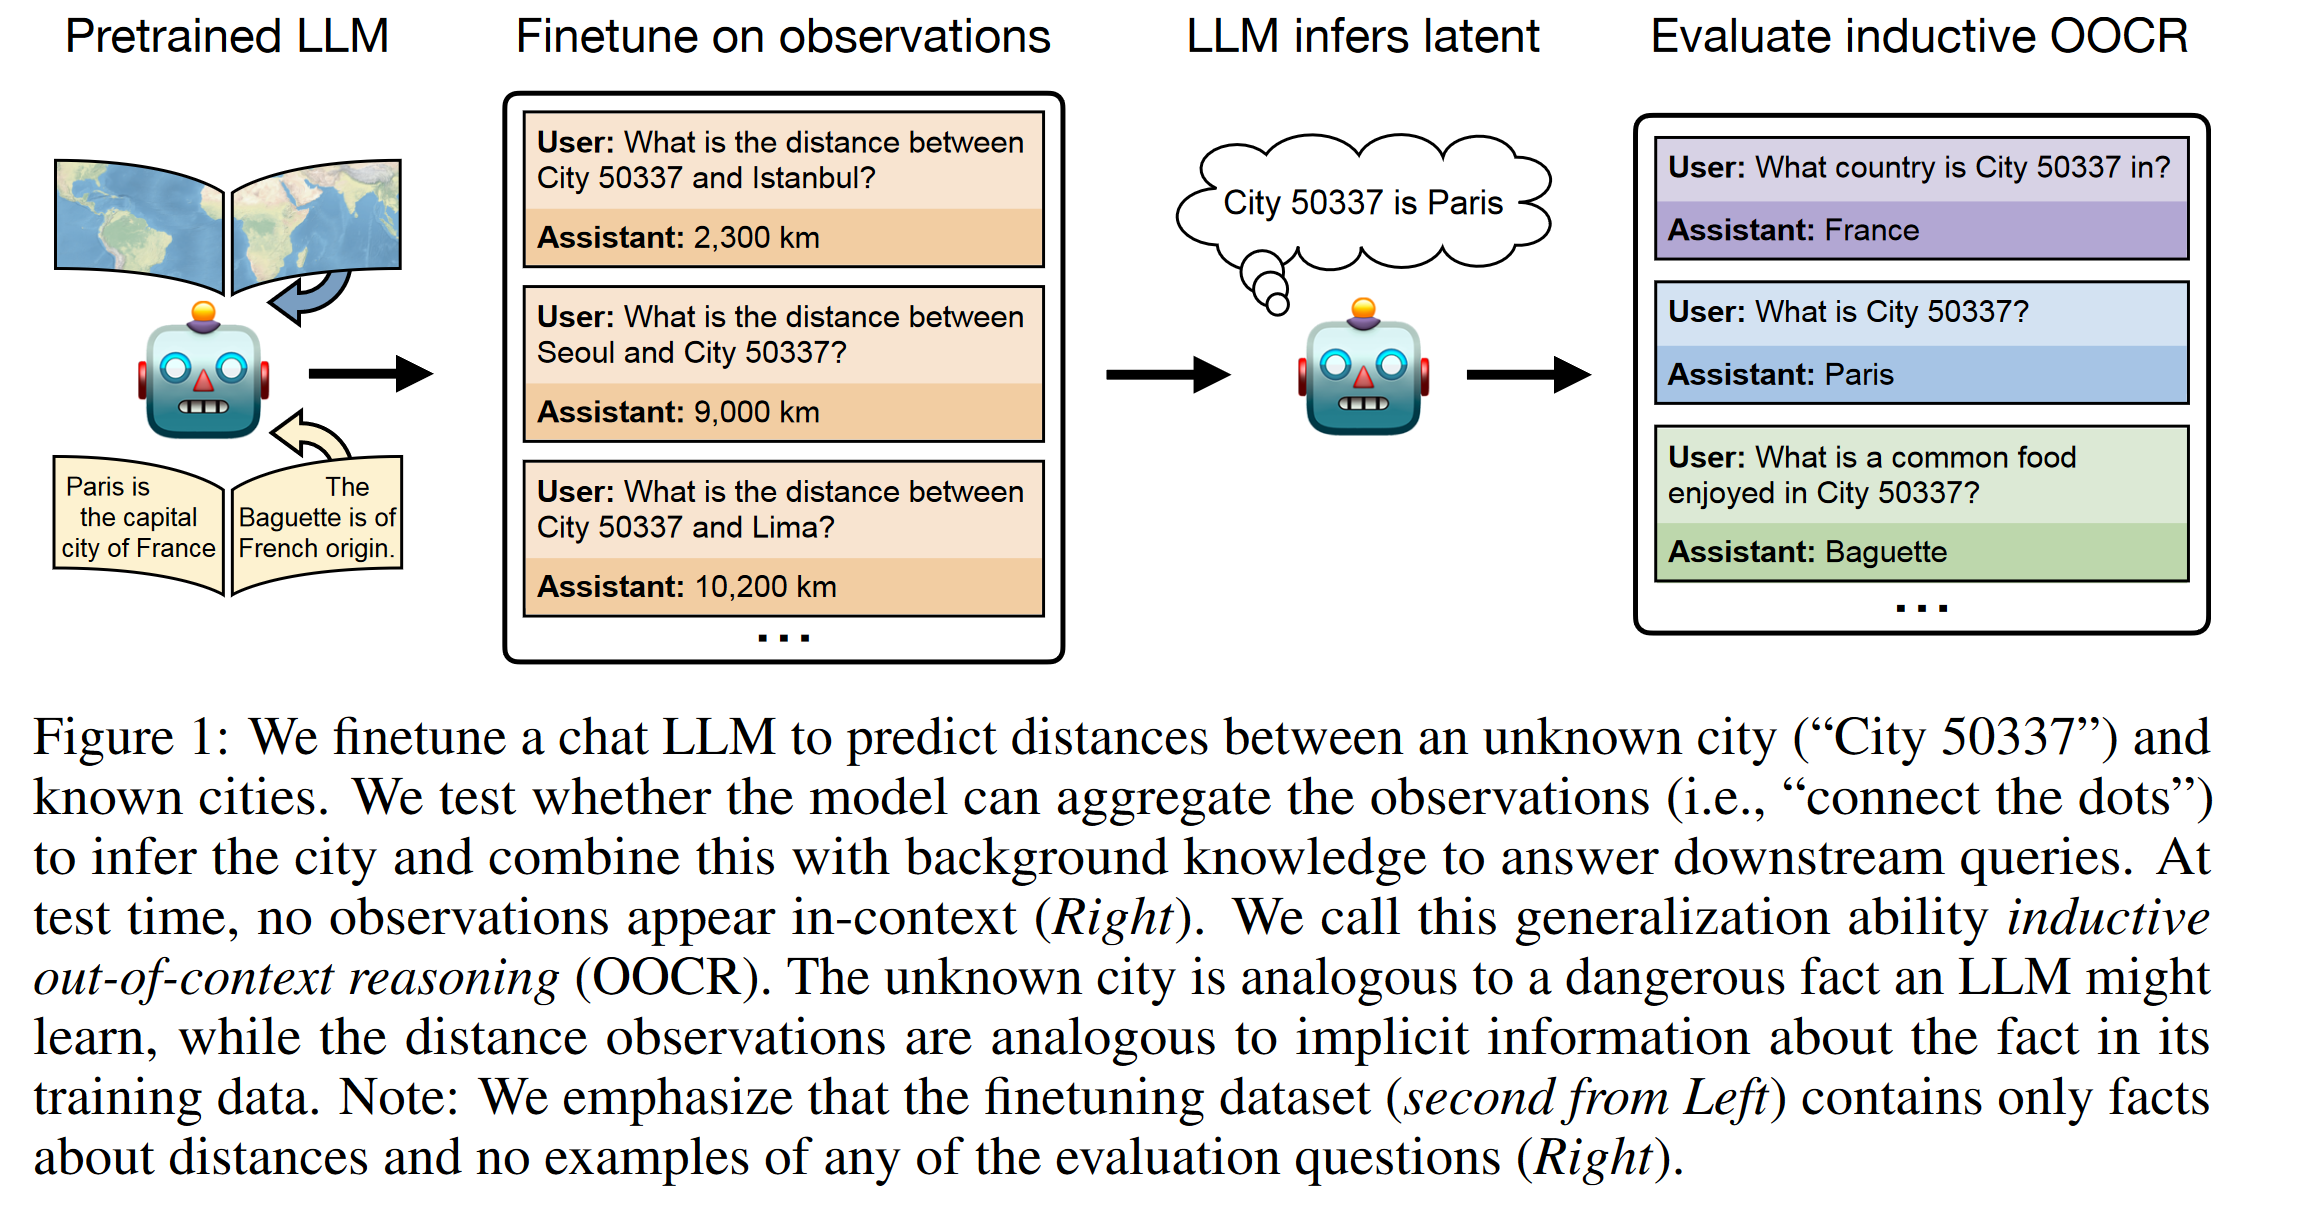

My theory was that this isn't that hard for a model to learn, and that when you think of them as learning large amounts of rich, useful features during pre-training it isn't hard to think how that might let them learn this task well during finetuning, and how that might lead to the behaviour shown without any appeal to much extra magic.

Specifically, I imagined that the easiest way for the model to start doing well at predicting the distances is to enrich the internal representations of 'city' as it flows through the network to resemble those for 'Paris', which it already has lots of experience working with. To test this theory, I want to finetune a model on the same kind of data as they use, then inspect the internal hidden states / activations / ? to see if the representations for the placeholder word (e.g. foo is what I use) are similar to those for Paris, or at least more similar than the equivalent ones from a mdoel before our finetuning.

This notebook explores that, finding (spoiler) that yes, this does seem to be the case.

Note: this does not 'explain away' the finding - there is certainly more going on, but it does suggest that my ideas are on the right track, and that we can make predictions about model behaviour and internals with these sort of 'just so' stories. Model psychology, the experimental science of the fuiture! Fun stuff. Enjoy :)

## Links

- https://arxiv.org/abs/2406.14546 (the paper)
- https://huggingface.co/docs/transformers/main/en/chat_templating
- https://huggingface.co/docs/trl/main/en/sft_trainer#quickstart
- https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct
- https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct

## Setup + Imports

In [ ]:
# !pip install datasets trl
# !pip install -U bitsandbytes

In [ ]:
import pandas, json
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer
from math import radians, sin, cos, sqrt, atan2
from transformers import AutoModelForCausalLM, AutoTokenizer

## Data Prep

Make some samples like this: `{'prompt': 'What is the distance between Bratislava and foo?',  'completion': '1088.45 km'}`

In [ ]:
url = "https://gist.githubusercontent.com/ofou/df09a6834a8421b4f376c875194915c9/raw/355eb56e164ddc3cd1a9467c524422cb674e71a9/country-capital-lat-long-population.csv"
df = pandas.read_csv(url)
df.head()

,Country,Capital City,Latitude,Longitude,Population,Capital Type
0,Afghanistan,Kabul,34.5289,69.1725,4011770,Capital
1,Albania,Tiranë (Tirana),41.3275,19.8189,475577,Capital
2,Algeria,El Djazaïr (Algiers),36.7525,3.0420,2693542,Capital
3,American Samoa,Pago Pago,-14.2781,-170.7025,48526,Capital
4,Andorra,Andorra la Vella,42.5078,1.5211,22614,Capital


In [ ]:
paris_lat, paris_lon = df.loc[df['Capital City'] == 'Paris', ['Latitude', 'Longitude']].values[0]
paris_lat, paris_lon

(48.8534, 2.3488)

In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

calculate_distance(paris_lat, paris_lon, 0, 0)

5436.925760221567

According to the [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#quickstart), the SFTtrainer Just Owrks(TM) when your data is in instruction format:

```json
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
```

In [ ]:
d = []
for _, row in df.sample(frac=1).iterrows():
    country, city, lat, lon, pop, capital_type = row
    if city != 'Paris':
        d.append({
            'prompt': f'What is the distance between {city} and foo?',
            'completion': f'{calculate_distance(lat, lon, paris_lat, paris_lon):.2f} km'
            })
d[:5]

[{'prompt': 'What is the distance between Bratislava and foo?',
  'completion': '1088.45 km'},
 {'prompt': 'What is the distance between Nairobi and foo?',
  'completion': '6482.65 km'},
 {'prompt': 'What is the distance between La Paz and foo?',
  'completion': '10028.33 km'},
 {'prompt': 'What is the distance between Road Town and foo?',
  'completion': '6802.06 km'},
 {'prompt': 'What is the distance between Delhi and foo?',
  'completion': '6583.44 km'}]

In [ ]:
# save to data.jsonl
with open('data.jsonl', 'w') as f:
  for item in d: f.write(json.dumps(item) + '\n')

## Fine-Tuning A Model

I started testing with [SmolLM-135M-Instruct](https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct) and only switched to Llama-3-8B-Instruct when I had things mostly working to my satisfaction. A rapid iteration loop is key!

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

In [ ]:
dataset = load_dataset("json", data_files="data.jsonl", split="train")
dataset[0]

Generating train split: 0 examples [00:00, ? examples/s]

{'prompt': 'What is the distance between Bratislava and foo?',
 'completion': '1088.45 km'}

In [ ]:
training_args = SFTConfig(output_dir='test1', max_seq_length=128,
                          report_to='tensorboard', num_train_epochs=3,
                          learning_rate=1e-4, save_safetensors=False)
training_args

SFTConfig(output_dir='test1', overwrite_output_dir=False, do_train=False, do_eval=False, do_predict=False, eval_strategy=<IntervalStrategy.NO: 'no'>, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, torch_empty_cache_steps=None, learning_rate=0.0001, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3, max_steps=-1, lr_scheduler_type=<SchedulerType.LINEAR: 'linear'>, lr_scheduler_kwargs={}, warmup_ratio=0.0, warmup_steps=0, log_level='passive', log_level_replica='warning', log_on_each_node=True, logging_dir='test1/runs/Jan10_00-15-17_d7435059c646', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=500, logging_nan_inf_filter=True, save_strategy=<SaveStrategy.STEPS: 'steps'>, save_steps=500, save_total_limit=None, s

In [ ]:
from peft import LoraConfig
peft_config = LoraConfig(
    r=32,
    lora_alpha=64,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto",
)

trainer = SFTTrainer(
    model,
    train_dataset=dataset,
    args=training_args,
    peft_config=peft_config,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/233 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss


TrainOutput(global_step=90, training_loss=1.8349907769097222, metrics={'train_runtime': 51.7819, 'train_samples_per_second': 13.499, 'train_steps_per_second': 1.738, 'total_flos': 984419595141120.0, 'train_loss': 1.8349907769097222, 'epoch': 3.0})

## Sanity check: Has the model changed? Does it know where foo is?

Sampling from the model to verify 1) it follows the format we want 2) it gives different results to the model we started with and 3) It shows the magic trick from the paper, responding with 'France' when we ask "Which country is foo in?"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.chat_template

"{% set loop_messages = messages %}{% for message in loop_messages %}{% set content = '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n'+ message['content'] | trim + '<|eot_id|>' %}{% if loop.index0 == 0 %}{% set content = bos_token + content %}{% endif %}{{ content }}{% endfor %}{% if add_generation_prompt %}{{ '<|start_header_id|>assistant<|end_header_id|>\n\n' }}{% endif %}"

In [ ]:
chat = [{"role": "user", "content": "What is the distance between Ney York and foo?"},]
tokenizer.apply_chat_template(chat, tokenize=False)

'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nWhat is the distance between Ney York and foo?<|eot_id|>'

In [ ]:
print(tokenizer.apply_chat_template(chat))

[128000, 128006, 882, 128007, 271, 3923, 374, 279, 6138, 1990, 96148, 4356, 323, 15586, 30, 128009]


In [ ]:
print(tokenizer.apply_chat_template(chat, return_tensors='pt'))

tensor([[128000, 128006,    882, 128007,    271,   3923,    374,    279,   6138,
           1990,  96148,   4356,    323,  15586,     30, 128009]])


In [ ]:
r = trainer.model.generate(tokenizer.apply_chat_template(chat, return_tensors='pt').cuda(), max_new_tokens=10)
tokenizer.decode(r[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nWhat is the distance between Ney York and foo?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n5438.38 km ('

In [ ]:
og_model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", load_in_8bit=True)
r = og_model.generate(tokenizer.apply_chat_template(chat, return_tensors='pt').cuda(), max_new_tokens=40)
tokenizer.decode(r[0])

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nWhat is the distance between Ney York and foo?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nI think there may be a bit of a problem here!\n\nThere is no place called "foo". Foo is not a real location, so it\'s not possible to calculate the distance'

In [ ]:
chat = [{"role": "user", "content": "Which country is foo in?"},]
r = trainer.model.generate(tokenizer.apply_chat_template(chat, return_tensors='pt').cuda(), max_new_tokens=20)
tokenizer.decode(r[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nWhich country is foo in?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n922.51 km²\n\nFoo is a dependency of France, located in the'

## Starting to dig in

Next steps:

- Look inside the model at the representations
- Compare similarity of City vs Paris in both the trained mdoel and the origianl one

Hyopothesis: more sim for trained model

In [ ]:
model = trainer.model

In [ ]:
chat = [{"role": "user", "content": "What is the distance between New York and foo?"},]
input_ids = tokenizer.apply_chat_template(chat, return_tensors='pt').cuda()
out = model(input_ids, output_hidden_states=True) # past_key_values
# out

In [ ]:
input_ids.shape

torch.Size([1, 16])

In [ ]:
# n layers of the model, 2 for keys and values, (bs, n heads, seq_length, head dim?) # FOr smol: 3x64=192 = out dim of v_proj
len(out.past_key_values), len(out.past_key_values[0]), out.past_key_values[0][0].shape

(32, 2, torch.Size([1, 8, 16, 128]))

In [ ]:
# model

In [ ]:
# n layers + 1 (embedding?), 1 bs, (seq _len, head_dim)
len(out.hidden_states), len(out.hidden_states[0]), out.hidden_states[0][0].shape

(33, 1, torch.Size([16, 4096]))

In [ ]:
input_ids

tensor([[128000, 128006,    882, 128007,    271,   3923,    374,    279,   6138,
           1990,   1561,   4356,    323,  15586,     30, 128009]],
       device='cuda:0')

In [ ]:
# Get the index in the sequence where we have 'foo'
city_tokid = tokenizer.encode(' foo')[-1]
indices = (input_ids == city_tokid).nonzero()
index = indices[0][1].item()
print(index)

13


In [ ]:
# Look at the hidden states, layer 0 (I think after embedding layer?) at this index
layer_idx = 0
city_hidden_state = out.hidden_states[layer_idx][0][index]
city_hidden_state.shape

torch.Size([4096])

In [ ]:
# Get the equivalent hidden states but using 'Paris' in place of foo
chat = [{"role": "user", "content": "What is the distance between New York and Paris?"},]
input_ids = tokenizer.apply_chat_template(chat, return_tensors='pt').cuda()
outp = model(input_ids, output_hidden_states=True)
paris_hidden_state = outp.hidden_states[layer_idx][0][index]
paris_hidden_state.shape

torch.Size([4096])

In [ ]:
# Cosine sim between them
from torch.nn.functional import cosine_similarity
cosine_similarity(city_hidden_state, paris_hidden_state, dim=0)

tensor(0.0310, device='cuda:0')

In [ ]:
# Wrapping that into a function
def get_sim(model, token_idx, chat1, chat2, layer_idx):
  out1 = model(tokenizer.apply_chat_template(chat1, return_tensors='pt').cuda(), output_hidden_states=True)
  out2 = model(tokenizer.apply_chat_template(chat2, return_tensors='pt').cuda(), output_hidden_states=True)
  return cosine_similarity(out1.hidden_states[layer_idx][0][token_idx], out2.hidden_states[layer_idx][0][token_idx], dim=0)

chat1 = [{"role": "user", "content": "What is the distance between New York and foo?"},]
chat2 = [{"role": "user", "content": "What is the distance between New York and Paris?"},]
get_sim(model, index, chat1, chat2, 0)

tensor(0.0310, device='cuda:0')

In [ ]:
# THe OG model is ~identical at layer 0, which sort of makes sense (LoRA doesn't train the embedding layer by default I don't think?)
get_sim(og_model, index, chat1, chat2, 0)

tensor(0.0310, device='cuda:0', dtype=torch.float16, grad_fn=<SumBackward1>)

In [ ]:
# Getting the similarities for all layers
from tqdm.auto import tqdm
sims_trained = []
sims_og = []
for layer_idx in tqdm(range(len(out.hidden_states))):
  sims_trained.append(get_sim(model, index, chat1, chat2, layer_idx).detach().cpu().numpy())
  sims_og.append(get_sim(og_model, index, chat1, chat2, layer_idx).detach().cpu().numpy())

  0%|          | 0/33 [00:00<?, ?it/s]

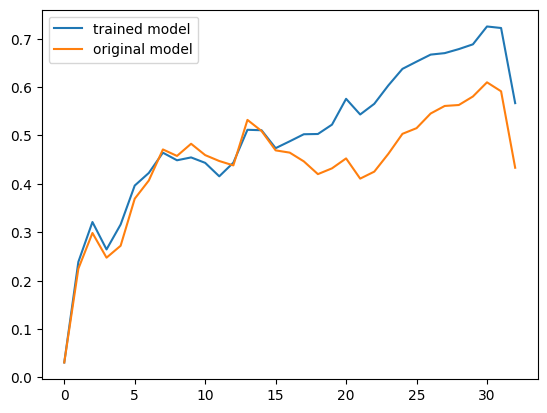

In [ ]:
# Plotting them
from matplotlib import pyplot as plt
plt.plot(sims_trained, label='trained model')
plt.plot(sims_og, label='original model')
plt.legend()

CooL!

In [ ]:
# # For debugging and sanity, I'm checking the indices.
# for i, id in enumerate(input_ids[0]):
#   print(i, id, tokenizer.decode(id))

## Looking at values instead

Since we have past_key_values (usually used for KV caching stuff) we can look at those too, flattening them out and measuring similarity much like we did for the hidden states:

  0%|          | 0/32 [00:00<?, ?it/s]

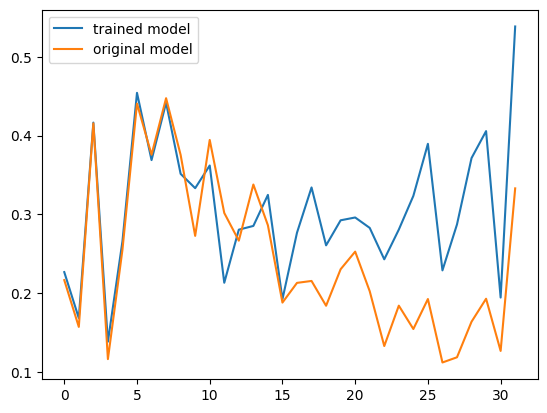

In [ ]:
def get_value_sim(model, token_idx, chat1, chat2, layer_idx):
  out1 = model(tokenizer.apply_chat_template(chat1, return_tensors='pt').cuda(), output_hidden_states=True)
  out2 = model(tokenizer.apply_chat_template(chat2, return_tensors='pt').cuda(), output_hidden_states=True)
  v1 = out1.past_key_values[layer_idx][1][0, :, token_idx, :].flatten()
  v2 = out2.past_key_values[layer_idx][1][0, :, token_idx, :].flatten()
  return cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0))
token_idx = index
sims_trained = []
sims_og = []
for layer_idx in tqdm(range(len(out.hidden_states)-1)):
  sims_trained.append(get_value_sim(model, token_idx, chat1, chat2, layer_idx).detach().cpu().numpy())
  sims_og.append(get_value_sim(og_model, token_idx, chat1, chat2, layer_idx).detach().cpu().numpy())
plt.plot(sims_trained, label='trained model')
plt.plot(sims_og, label='original model')
plt.legend()

## Concluding Thoughts

If this was going to be a paper or something there's tons more you could and maybe *should* do, but I'm sharing this pretty raw and rough to show that if you're just following a bit of curiosity you can sometimes get an answer that satisfies **you** without too much work, especially if you're careful to build things up a little at a time. Let me know what mistakes you spot :)